# Unsupervised Learning for anomaly detection in options pricing

**Note**: This notebook is part of a broader work for predicting stock prices. The outcome (identified anomaly) is a feature (input) in a **LSTM** model (within a **GAN** architecture)- <a href='https://github.com/borisbanushev/stockpredictionai'>link to the repo</a>.

#### 1. Why using options pricing data and anomalies as inputs in the GAN?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Options valuation is a very difficult task. It entails using a lot of data points (some are listed below) and some of them are quite subjective (such as the implied volatility - see below) and difficult to calculate precisely. As an example let us check the calculation for the call's _Theta_ - $\theta$:

<center><img src='imgs/Options/calltheta.png'></img></center>

where (among others) $N(d_1)$ and $N(d_2)$ are cumulative distribution functions for a standard normal distribution, respectively:

<center><img src='imgs/Options/optionsinfo.png'></img></center>

and the **Black-Scholes** formula which is used for calculating the options price itself. The formula for calculating the price of a European call option with maturity in $t$ and current price of $S_0$ is:

<center><img src='imgs/Options/bsmcall.png'></img></center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Second, the Black-Scholes model, famously known as _binomial tree_, requires a lot of assumptions to be met in order for the model to be accurate. These rules, however, most often cannot be met in real life. Some of them include:
- the model assumes that the underlying volatility ($\sigma$) is constant over the life of the option and stays unaffected by changes in the underlying stock price levels. Many times the volatility changes with changes in the strike price - the higher the difference between strike and the underlying price, the higher the volatility. This phenomenon is called the **Volatility smile** (refer to the chart below),
- the model assumes constant risk-free rate of return (something difficult to anticipate as the global economy changes every day),
- the model does not account for liquidity risk and additional fees/charges,
- it assumes that stock returns follow lognormal distribution (meaning that the model ignores the possibility of large price deviations, surge or drop, something that can easily be observed in real trading),
- assumes no dividend payout. Dividend payouts change the current valuation of the stock, which in turn should change the options price,
- the model is applicable only for European options.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The fact that the aforementioned assumptions can rarely be met in real-life is exactly why anomalies can be observed. This, in turn, creates a lot of opportunities we can explore and exploit with machine/deep learning, such as arbitrage trading.

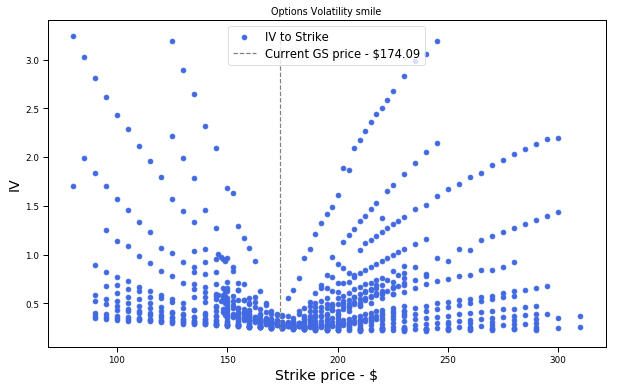

In [88]:
"""
===== IMPORTANT:
Execute the following code cells (below) first in order to instantiate the 'options_df' dataframe
"""

curr_price_ = options_df.iloc[0,0]
plt.figure(figsize=(10, 6))
plt.scatter(options_df.Strike, options_df.IVAsk, label='IV to Strike', \
            c='royalblue')
plt.vlines(curr_price_, options_df.IVAsk.min(), \
           options_df.IVAsk.max(), \
           label='Current GS price - ${}'.format(curr_price_), \
           linestyles='--', colors='gray')
plt.xlabel('Strike price - $')
plt.ylabel('IV')
plt.title('Options Volatility smile')
plt.legend(fontsize='large')
plt.savefig('imgs/Options/volatilitysmile.jpg', dpi=100)
plt.show()

_Not a perfect smile at this example, but we only used data for one day._

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The difficulty in options valuation creates a lot of opportunities for arbitrage (something we will explore in another post). So let's go back to our original idea - predicting stock prices. As we already mentioned, we want to use as many different types of features in order to find, and account for, events, patterns, etc that make the prices move in certain directions - that is why we have fundamental features, technical, Fourier transforms, and so on. In my opinion, the options data brings a lot of information about the stock from a different perspective - hence is valuable for us. On the other hand, since the options are, in their essence, contracts whereby the buyer has the option to exercise a buy or sell trade in the future, means that the companies that create the options valuations spend considerable time trying to predict the future movements of the underlying stock. This leads to the idea that if, on a certain day, the price of the options contract deviates from the average (and from the rules of options - find a couple of examples below) there must be something happening with the stock on that day (in our terms - anomaly). This anomaly can in turn, combined with other features (or depending on them), somehow dictate the future movement of the stock.

**Note** : Knowledge of the options greeks is important in order for us to fully understand whether the anomaly detections works (and how). So we will briefly cover them:


- **Implied volatility** $\sigma$: The implied volatility is a measure the estimate of how much the price could change. A high number means that traders believe the option could make a large change. Basically, just a volatility index.
- **Delta**: The $\delta$ measures how much the option price would change in relation to the underlying stock price. A delta of 0.5 means the option would change 50 cents for every 1 dollar the stock moves. $\delta$ is the first derivative of the price.
- **Gamma**: The $\gamma$ measures how fast the Delta will change when the stock price changes. A high number means this is a very explosive option, and could gain or loss value quickly. This is the second derivative of the price.
- **Theta**: The $\theta$ measures how fast the option is losing value per day due to time decay. As the expiration day arrives, the theta increases.
- **Vega**: The vega (a measure of how sensitive the option price is to a change in the implied volatility. Options that are way _out of the money_, or have a long time until expiration are more sensitive to a change in implied volatility)

#### 2. What options pricing data do we have?

The data is from historicaloptiondata.com.

In [6]:
# Filtered options data for Goldman Sachs
options_df = pd.read_csv('option_GS_df.csv', parse_dates=["Expiration", ' DataDate'])
options_df['date_diff'] = (options_df['Expiration'] - options_df[' DataDate']).dt.days
options_df['Spread'] = options_df['Ask'] - options_df['Bid']

In [8]:
options_df.head()

,UnderlyingPrice,OptionSymbol,Type,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,...,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega,AKA,date_diff,Spread
0,174.09,GS160108C00125000,call,2016-01-08,2016-01-05,125.0,0.0,46.95,50.80,0,...,0.0874,0.0,3.1911,1.0000,0.0000,0.0000,0.0000,GS160108C00125000,3,3.85
1,174.09,GS160108P00125000,put,2016-01-08,2016-01-05,125.0,0.0,0.00,0.31,0,...,1.9822,0.0,2.2141,-0.0150,0.0014,-0.2242,0.0053,GS160108P00125000,3,0.31
2,174.09,GS160108C00130000,call,2016-01-08,2016-01-05,130.0,0.0,41.80,45.80,0,...,0.0874,0.0,2.8946,1.0000,0.0000,0.0000,0.0000,GS160108C00130000,3,4.00
3,174.09,GS160108P00130000,put,2016-01-08,2016-01-05,130.0,0.0,0.00,0.31,0,...,1.7931,0.0,1.9882,-0.0175,0.0017,-0.2310,0.0060,GS160108P00130000,3,0.31
4,174.09,GS160108C00135000,call,2016-01-08,2016-01-05,135.0,0.0,36.95,40.90,0,...,0.0874,0.0,2.6480,1.0000,0.0000,0.0000,0.0000,GS160108C00135000,3,3.95


In [9]:
options_df.shape

(858, 22)

In [29]:
print(', '.join(x for x in options_df.columns))

UnderlyingPrice, OptionSymbol, Type, Expiration,  DataDate, Strike, Last, Bid, Ask, Volume, OpenInterest, T1OpenInterest, IVMean, IVBid, IVAsk, Delta, Gamma, Theta, Vega, AKA, date_diff, Spread


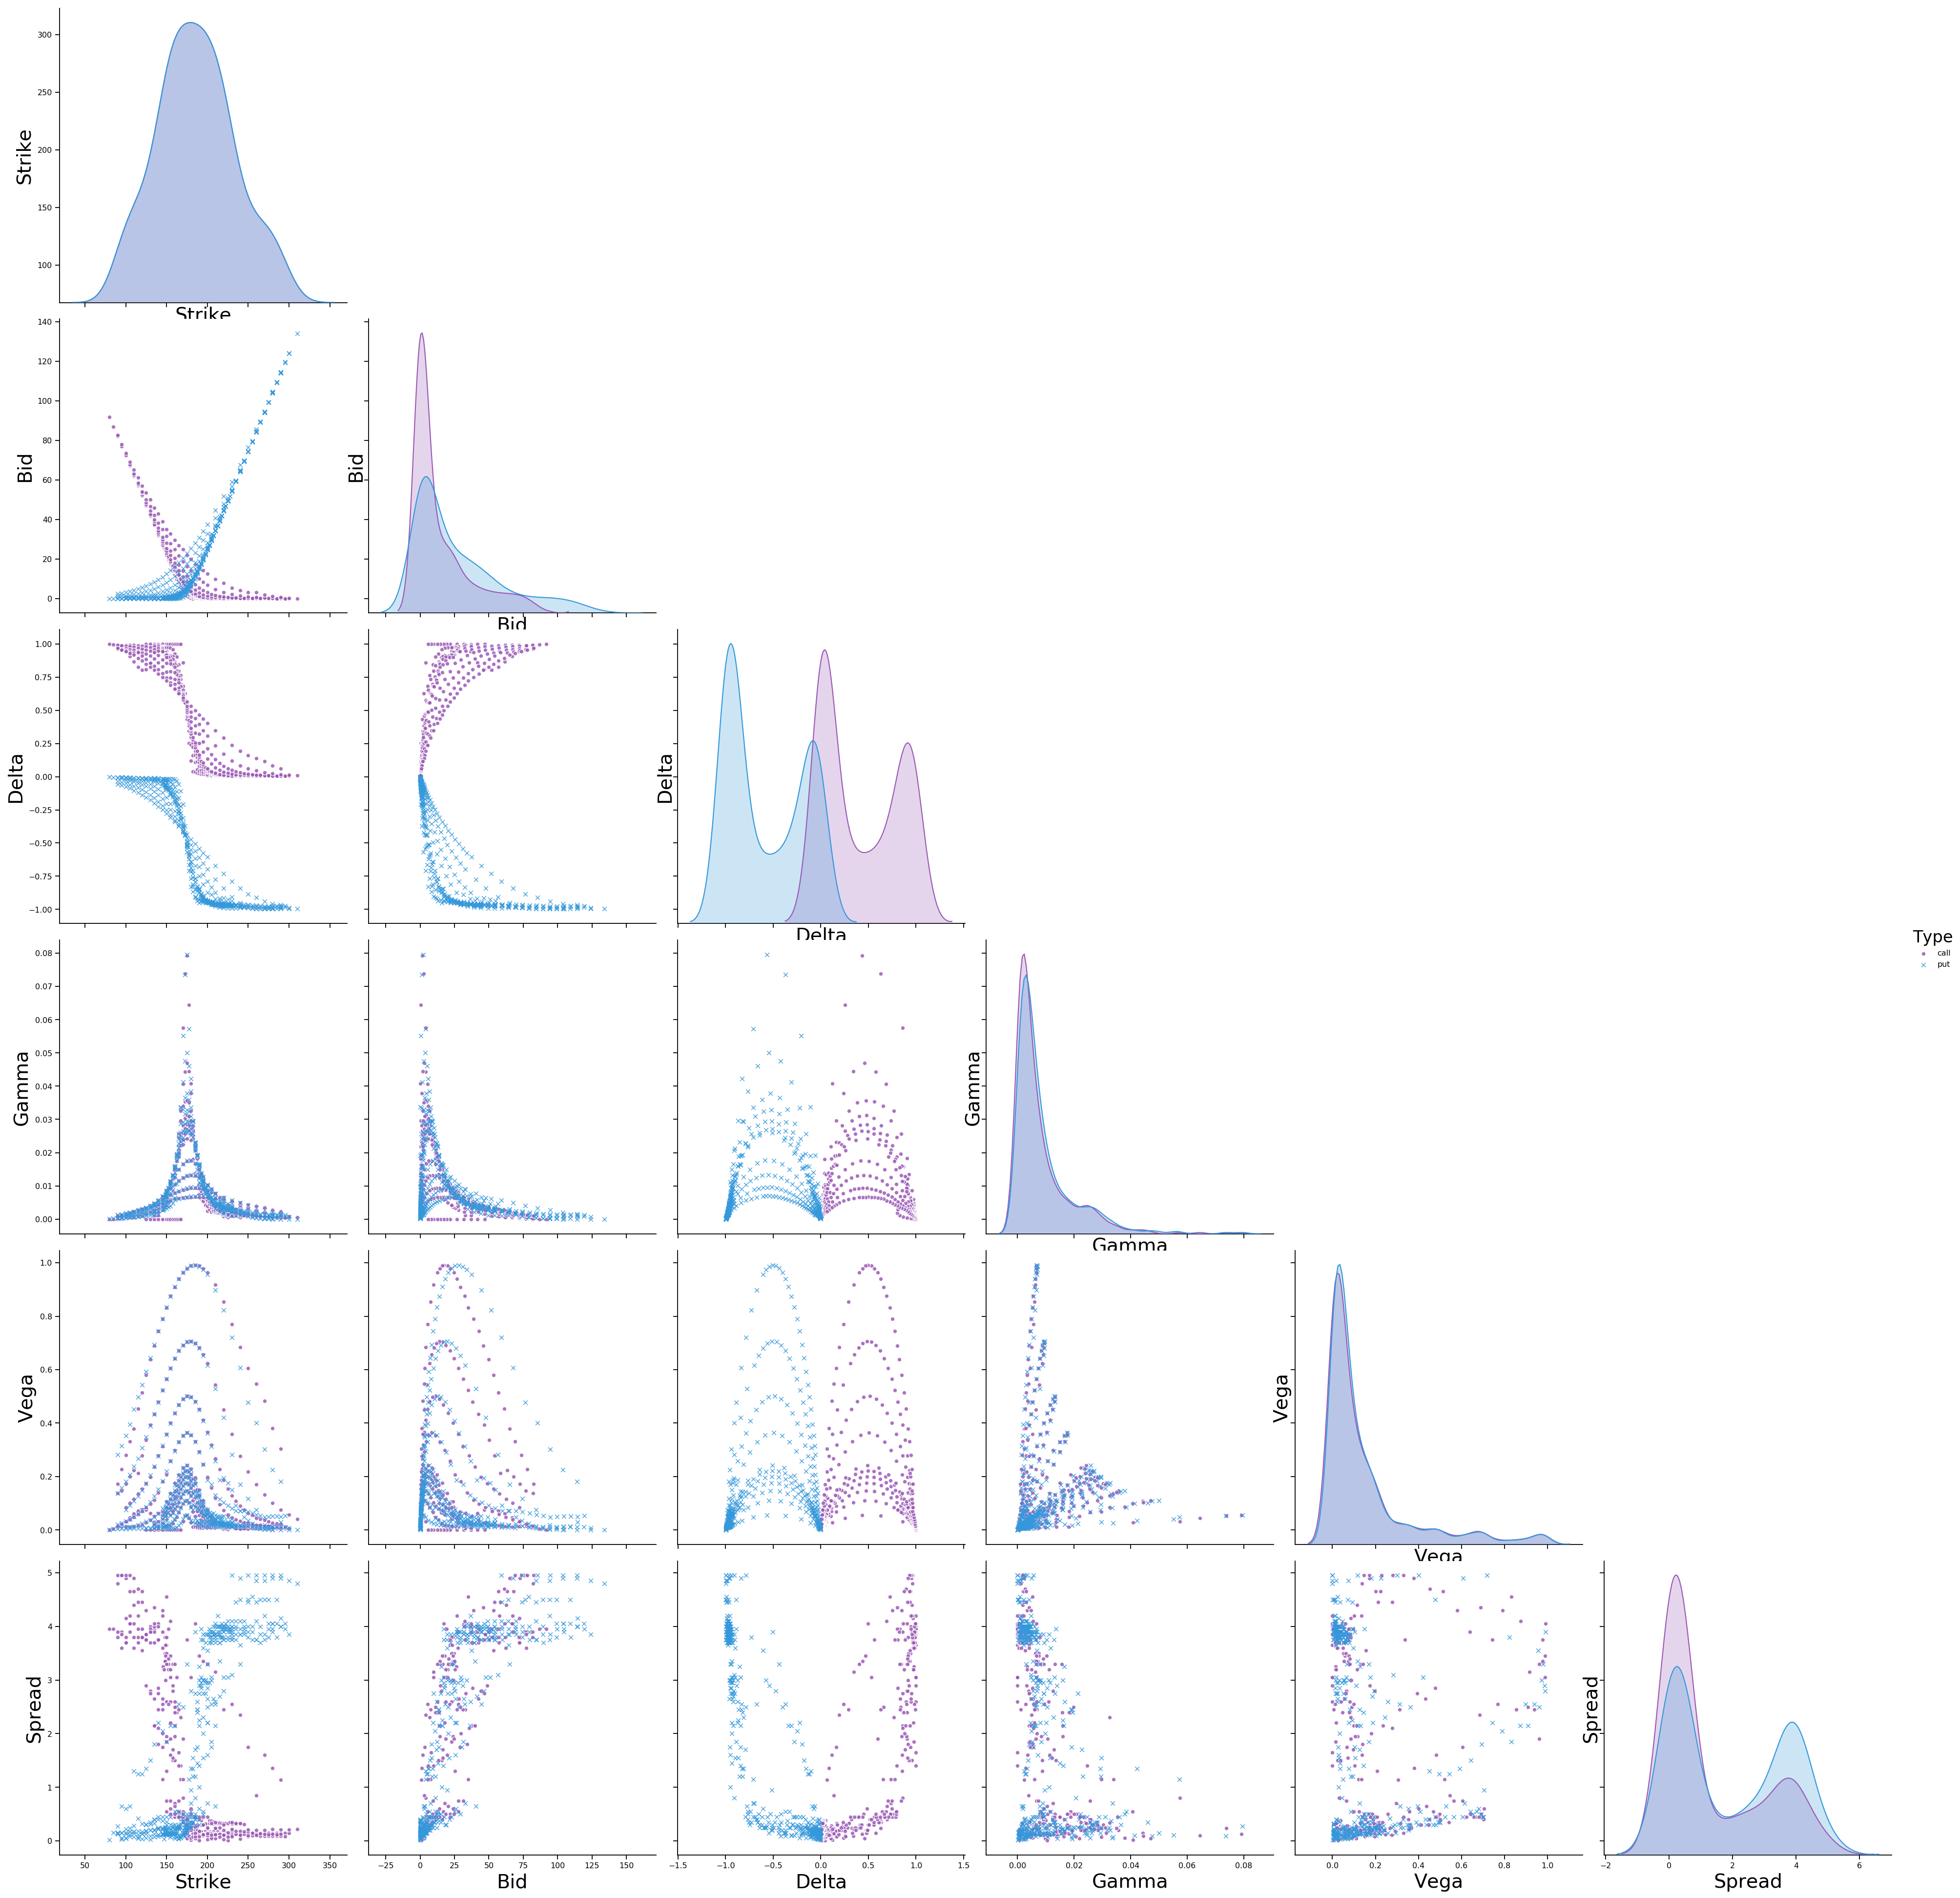

In [160]:
sns_options_colors = ["#9b59b6", "#3498db"]
sns_options_vars = ['Strike', 'Bid', 'Delta', \
                    'Gamma', 'Vega', 'Spread']

sns.set_palette(sns.color_palette(sns_options_colors))
sns.set_context("paper", rc={"axes.labelsize": 22})

options_g = sns.pairplot(options_df, \
                         vars=sns_options_vars, \
                         diag_kind='kde', \
                         hue='Type', \
                         markers=["o", "x"], \
                         plot_kws=dict(edgecolor='white', \
                                       linewidth=.85, alpha=.85), \
                         diag_kws=dict(shade=True),\
                         height=5)

for i, j in zip(*np.triu_indices_from(options_g.axes, 1)):
    options_g.axes[i, j].set_visible(False)
    
xlabels, ylabels = [], []    

for ax in options_g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in options_g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

i,j=0,0
for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        options_g.axes[j,i].xaxis.set_label_text(col_names_pairplot[xlabels[i]])
        options_g.axes[j,i].yaxis.set_label_text(col_names_pairplot[ylabels[j]])

plt.savefig('imgs/Options/options_pairplot.jpg')
plt.show()

**Note**: The purple-ish color represents the calls, and the blue - the puts.

#### 3. Unsupervised learning for finding outliers (anomaly)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**What would be an anomaly?** Anomaly in our case would be any mismatch in the logic of the options. **For example**, the Bid (or Ask) prices of two call options that have the same Strike price but, say, 1-2 days difference in the Exercise day should be almost identical (unless there is something unusual, which should somehow be accounted for in the greeks). So, a big difference in the Bid prices of these two options would not be 'normal'. Or, for instance, high Theta or small Vega on an (_OTM_) option with long time to expiration. And so on.

For the purpose of anomaly detection we will use **Isolation Forest**.

Let's visualize* the options data for one trading day (2016-01-05) and try to see if we can visually identify anomalies. Several things look suspicious that might (or not) be anomalies:
- in **Chart 2** - it is strange to have a put contract with much smaller delta than the contracts next to it considering the contract has the same characteristics - Average of bid/ask, difference between current and strike price, very very close expiration date - it is the option at the bottom with blue color surrounded by gray color puts. On the other side, there is a call with the same anomaly - the purple circle surrounded by gray ones.
- in **Chart 3** - (on the right side) there are several call options (we know they are calls because call options have a positive delta - between 0 and 1) with significantly lower ranges of Theta - the circles have theta less than -4.5, considering that the other options with same characteristics (close by) have thetas higher than -1.5.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Our main features of interest will be the Bid/Ask price (or the feature we have created - the average of those) and the Spread ($Ask - Bid$). Options of the same type, close Strike prices and expiration dates shouldn't, in theory, have significantly different prices and spread.

<table cellspacing=40 cellpadding=40 bgcolor="#000000">
    <tr cellspacing=40 cellpadding=40>
        <td style="padding:10px; background-color: while"><img src='imgs/Options/import/1.png' width=600 border=1></img></td>
        <td style="padding:10px; background-color: while"><img src='imgs/Options/import/2.png' width=600 border=1></img></td>
    </tr>
    <tr>
        <td style="padding:10px; background-color: while"><img src='imgs/Options/import/3.png' width=600 border=1></img></td>
        <td style="padding:10px; background-color: while; border-color: red"><img src='imgs/Options/import/4.png' width=600 border=1></img></td>
    </tr>
</table>

\* **Made these charts in Tableau.**

In [90]:
it_X_train = options_df[['Strike', 'Delta', 'Gamma', 'date_diff']]
it_X_train['s_k'] = options_df['UnderlyingPrice'] - options_df['Strike']
it_X_train['b_a_mean'] = (options_df['Bid'] + options_df['Ask']) / 2
it_X_train['b_a_mean'] = it_X_train['b_a_mean'].apply(lambda x: int(round(x, 0)))
it_X_train['s_k'] = it_X_train['s_k'].apply(lambda x: int(round(x, 0)))

In [91]:
col_names = {
    's_k' : 'Difference between Current and Strike prices',
    'b_a_mean': 'Average of Bid and Ask',
    'date_diff': 'Difference between Date of valuation and Exercise date',
    'Spread' : 'Spread', 'Delta': 'Delta', 'Gamma': 'Gamma',
    'Strike': 'Strike', 'Bid':'Bid', 'Ask':'Ask', 'Vega':'Vega', 'Type':'Type',
    'y' : 'Anomaly', 'Type': 'Option type (call or put)', 'Last': 'Last trading price'
}

In [92]:
print('The features we will use are {}.'.
      format(', '.join(col_names[x] for x in it_X_train.columns)))

The features we will use are Strike, Delta, Gamma, Difference between Date of valuation and Exercise date, Difference between Current and Strike prices, Average of Bid and Ask.


In [93]:
clf = IsolationForest(max_samples='auto', contamination=.025,\
                      n_estimators=10, \
                      random_state=19117, max_features=it_X_train.shape[1])
clf.fit(it_X_train)

y_pred_train = clf.predict(it_X_train)

In [16]:
it_X_train['y'] = y_pred_train

In [17]:
it_X_train['Type'] = options_df['Type']

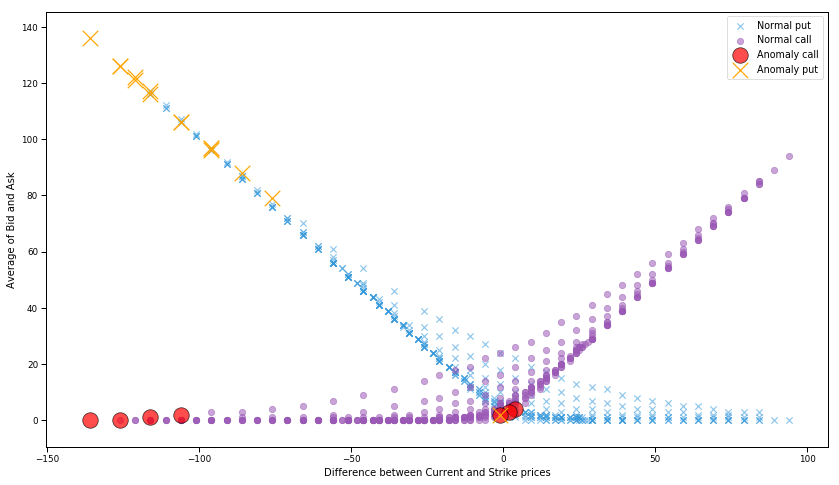

In [58]:
it_outlier = -1

sns_options_colors = ["#9b59b6", "#3498db"]
sns.set_palette(sns.color_palette(sns_options_colors))
sns.set_context("paper", rc={"axes.labelsize": 10})
plt.figure(figsize=(14, 8))

it_x_ = 's_k'
it_y_ = 'b_a_mean'


plt.scatter(it_X_train[(it_X_train['y']==1) & (it_X_train['Type']=='put')][it_x_], \
            it_X_train[(it_X_train['y']==1) & (it_X_train['Type']=='put')][it_y_], \
            label='Normal put', c=sns_options_colors[1], s=10*4, alpha=.55, marker='x')

plt.scatter(it_X_train[(it_X_train['y']==1) & (it_X_train['Type']=='call')][it_x_], \
            it_X_train[(it_X_train['y']==1) & (it_X_train['Type']=='call')][it_y_], \
            label='Normal call', c=sns_options_colors[0], s=10*4, alpha=.55, marker='o')

plt.scatter(it_X_train[(it_X_train['y']==-1) & (it_X_train['Type']=='call')][it_x_], \
            it_X_train[(it_X_train['y']==-1) & (it_X_train['Type']=='call')][it_y_], \
            label='Anomaly call', c='red', s=60*4, edgecolor='black', marker='o', alpha=.7)

plt.scatter(it_X_train[(it_X_train['y']==-1) & (it_X_train['Type']=='put')][it_x_], \
            it_X_train[(it_X_train['y']==-1) & (it_X_train['Type']=='put')][it_y_], \
            label='Anomaly put', c='orange', s=60*4, edgecolor='black', marker='x')

plt.xlabel(col_names[it_x_])
plt.ylabel(col_names[it_y_])
plt.legend(fontsize='medium')

plt.savefig('imgs/Options/it_result_options.jpg', dpi=200)
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;These are the anomalies identified by the isolation forest. It was funny to find out (despite not visible from the last chart as I couldn't seem to fix the Y-axis scales between python and Tableau) the identified anomalies (in red and orange colors in the last chart) are those we observed in the 4 charts above (**I cross-referenced the indexes of each contract**).

In [41]:
col_names_pairplot = {
    's_k' : 'Current minus Strike',
    'b_a_mean': 'Average of Bid and Ask',
    'date_diff': 'Date difference',
    'Spread' : 'Spread', 'Delta': 'Delta', 'Gamma': 'Gamma', 'Spread':'Spread',
    'Strike': 'Strike', 'Bid':'Bid', 'Ask':'Ask', 'Vega':'Vega'
}

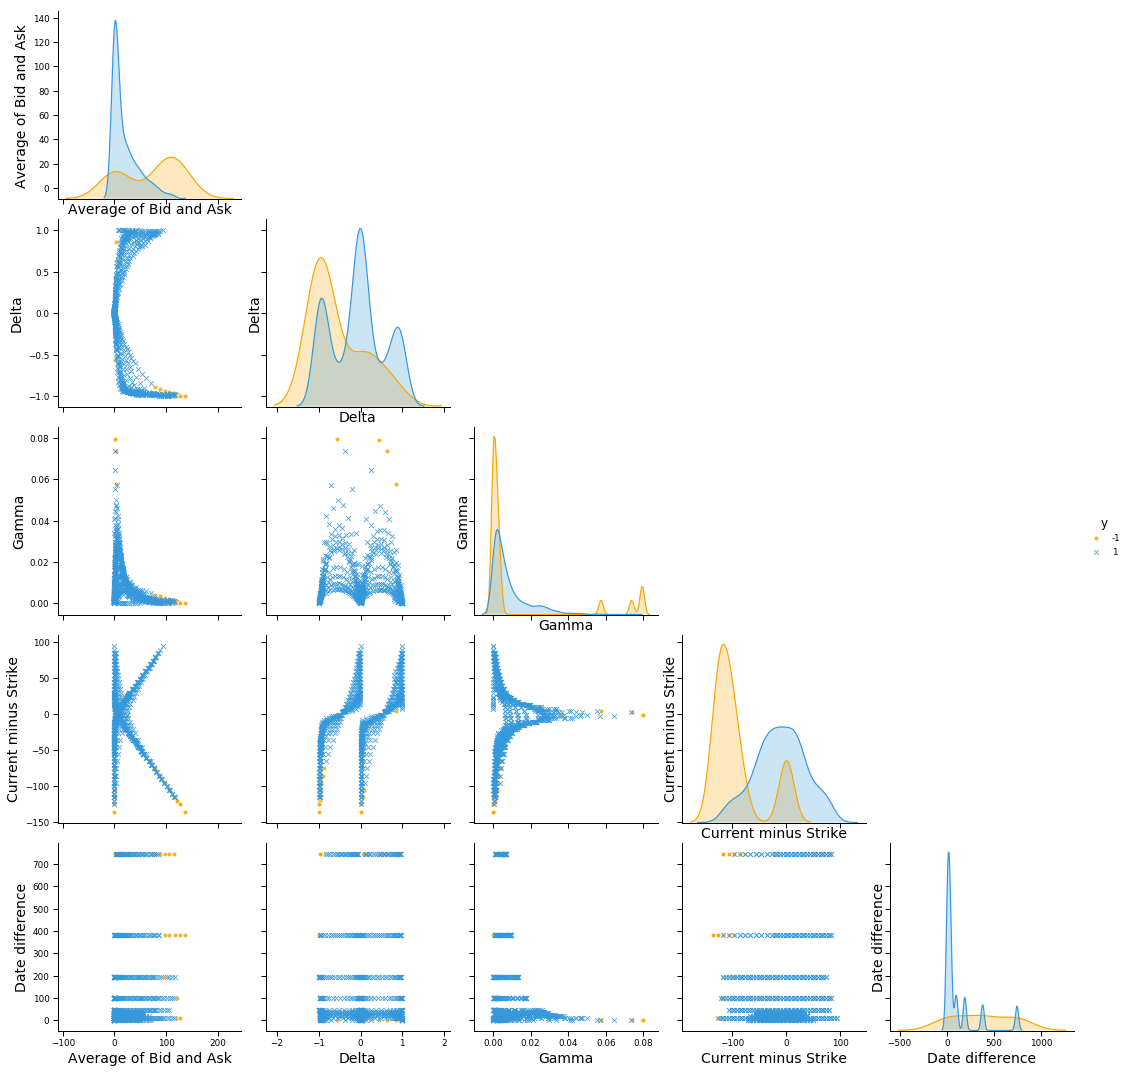

In [59]:
sns_options_colors = ["#f9a602", "#3498db"]

sns_options_vars = ['b_a_mean', 'Delta', 'Gamma', 's_k', 'date_diff']
sns.set_palette(sns.color_palette(sns_options_colors))
sns.set_context("paper", rc={"axes.labelsize": 14})

options_g = sns.pairplot(it_X_train, \
                         vars=sns_options_vars, \
                         diag_kind='kde', \
                         hue='y', \
                         markers=["o", "x"], \
                         plot_kws=dict(edgecolor='white', \
                                       linewidth=.85, alpha=.85), \
                         diag_kws=dict(shade=True),\
                         height=3)

for i, j in zip(*np.triu_indices_from(options_g.axes, 1)):
    options_g.axes[i, j].set_visible(False)

xlabels, ylabels = [], []    

for ax in options_g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in options_g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        options_g.axes[j,i].xaxis.set_label_text(col_names_pairplot[xlabels[i]])
        options_g.axes[j,i].yaxis.set_label_text(col_names_pairplot[ylabels[j]])

plt.savefig('imgs/Options/it_result_pairplot.jpg', dpi=100)
plt.show()

**Note**: The orange color points represent anomaly. The blue ones are normal.

Several observations can be made about anomalous option pricing samples from this pair-plot:
- they have average price (average of Bid and Ask) higher than the other options,
- they are equally distributed across different maturities (despite the original data being distributed mainly around closer maturities),
- they Current minus Strike price is not normally distributed as the original data.

#### 4. So what will we use from the options data and the anomaly detection?

The options data is quite large. For every trading day we have:
- the options prices for different maturities (time frame of the options contract, e.g. 90 days contract, 180 days, etc.),
- the options prices for different strike prices,
- the options prices for calls and puts,
- the greeks,
- in IV, IVBid, IVAsk, IVMean.

In [31]:
print('So for every day of the training data we have {} data points.'.\
      format(options_df.shape[0]*options_df.shape[1]))

So for every day of the training data we have 18876 data points.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Obviously we cannot include 18887 features for every day. So, we will include just the 60 and 90 days call and put prices with strikes equal to the current price (average of bid and ask), plus and minus 5, 10, and 20%. And also $\delta$, $\gamma$, and the spread. Total of 12 new features.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From the **anomaly detection** part we will create just a boolean feature showing whether there was any anomaly detected for that day for any strike price or expiration date. Of course, it would be much better to use a number to represent the severity or degree of deviation - we'll save it for a later stage. That would mean 13 new features added to our total dataset (total of 125 features altogether).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here I just showed how to attempt making anomaly detection for one day. For the LSTM I put the whole data (for all days) together (and increase the threshold for anomaly, of course). The date itself is not important for anomaly detection as we use the difference between the date of valuation and expiration date. For every anomaly, we assing 1 (representing anomaly) to the respective date in the training data.

**Note**: I am not a professional options trader or underwriter, so if anybody finds something that is wrong or doesn't make sense - I am open to suggestions.

**Note**: Using autoencoders also makes good sense for anomaly detection.

# Disclaimer <a class="anchor" id="disclaimer"></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**This notebook is entirely informative. None of the content presented in this notebook constitutes a recommendation that any particular security, portfolio of securities, transaction or investment strategy is suitable for any specific person. Futures, stocks and options trading involves substantial risk of loss and is not suitable for every investor. The valuation of futures, stocks and options may fluctuate, and, as a result, investors may lose more than their original investment.**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**All trading strategies are used at your own risk.**

Thanks for reading.

Best,
Boris